In [1]:
# https://www.openml.org/apis

import openml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


In [15]:
# Importar o dataset

suite = openml.study.get_suite(99)

task_id = 37
task = openml.tasks.get_task(task_id)    

dataset = openml.datasets.get_dataset(task.dataset_id)

X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)

# Visualizar o dataset

df = pd.DataFrame(X, columns=attribute_names)

y = y * 2 - 1
df['target'] = y

df.head()

df.to_csv('data.csv', index=False)

<AxesSubplot:xlabel='target', ylabel='count'>

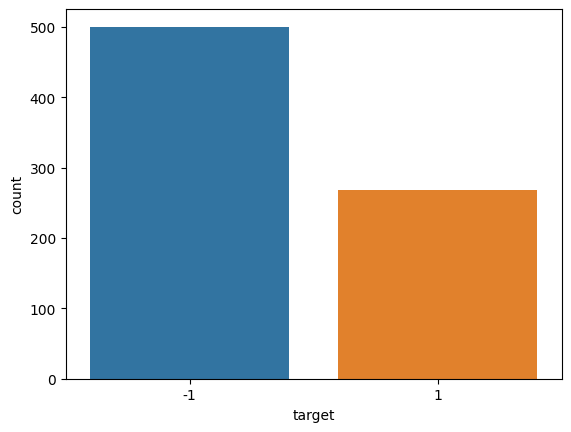

In [16]:
# Visualizar a distribuição das classes

sns.countplot(x='target', data=df)

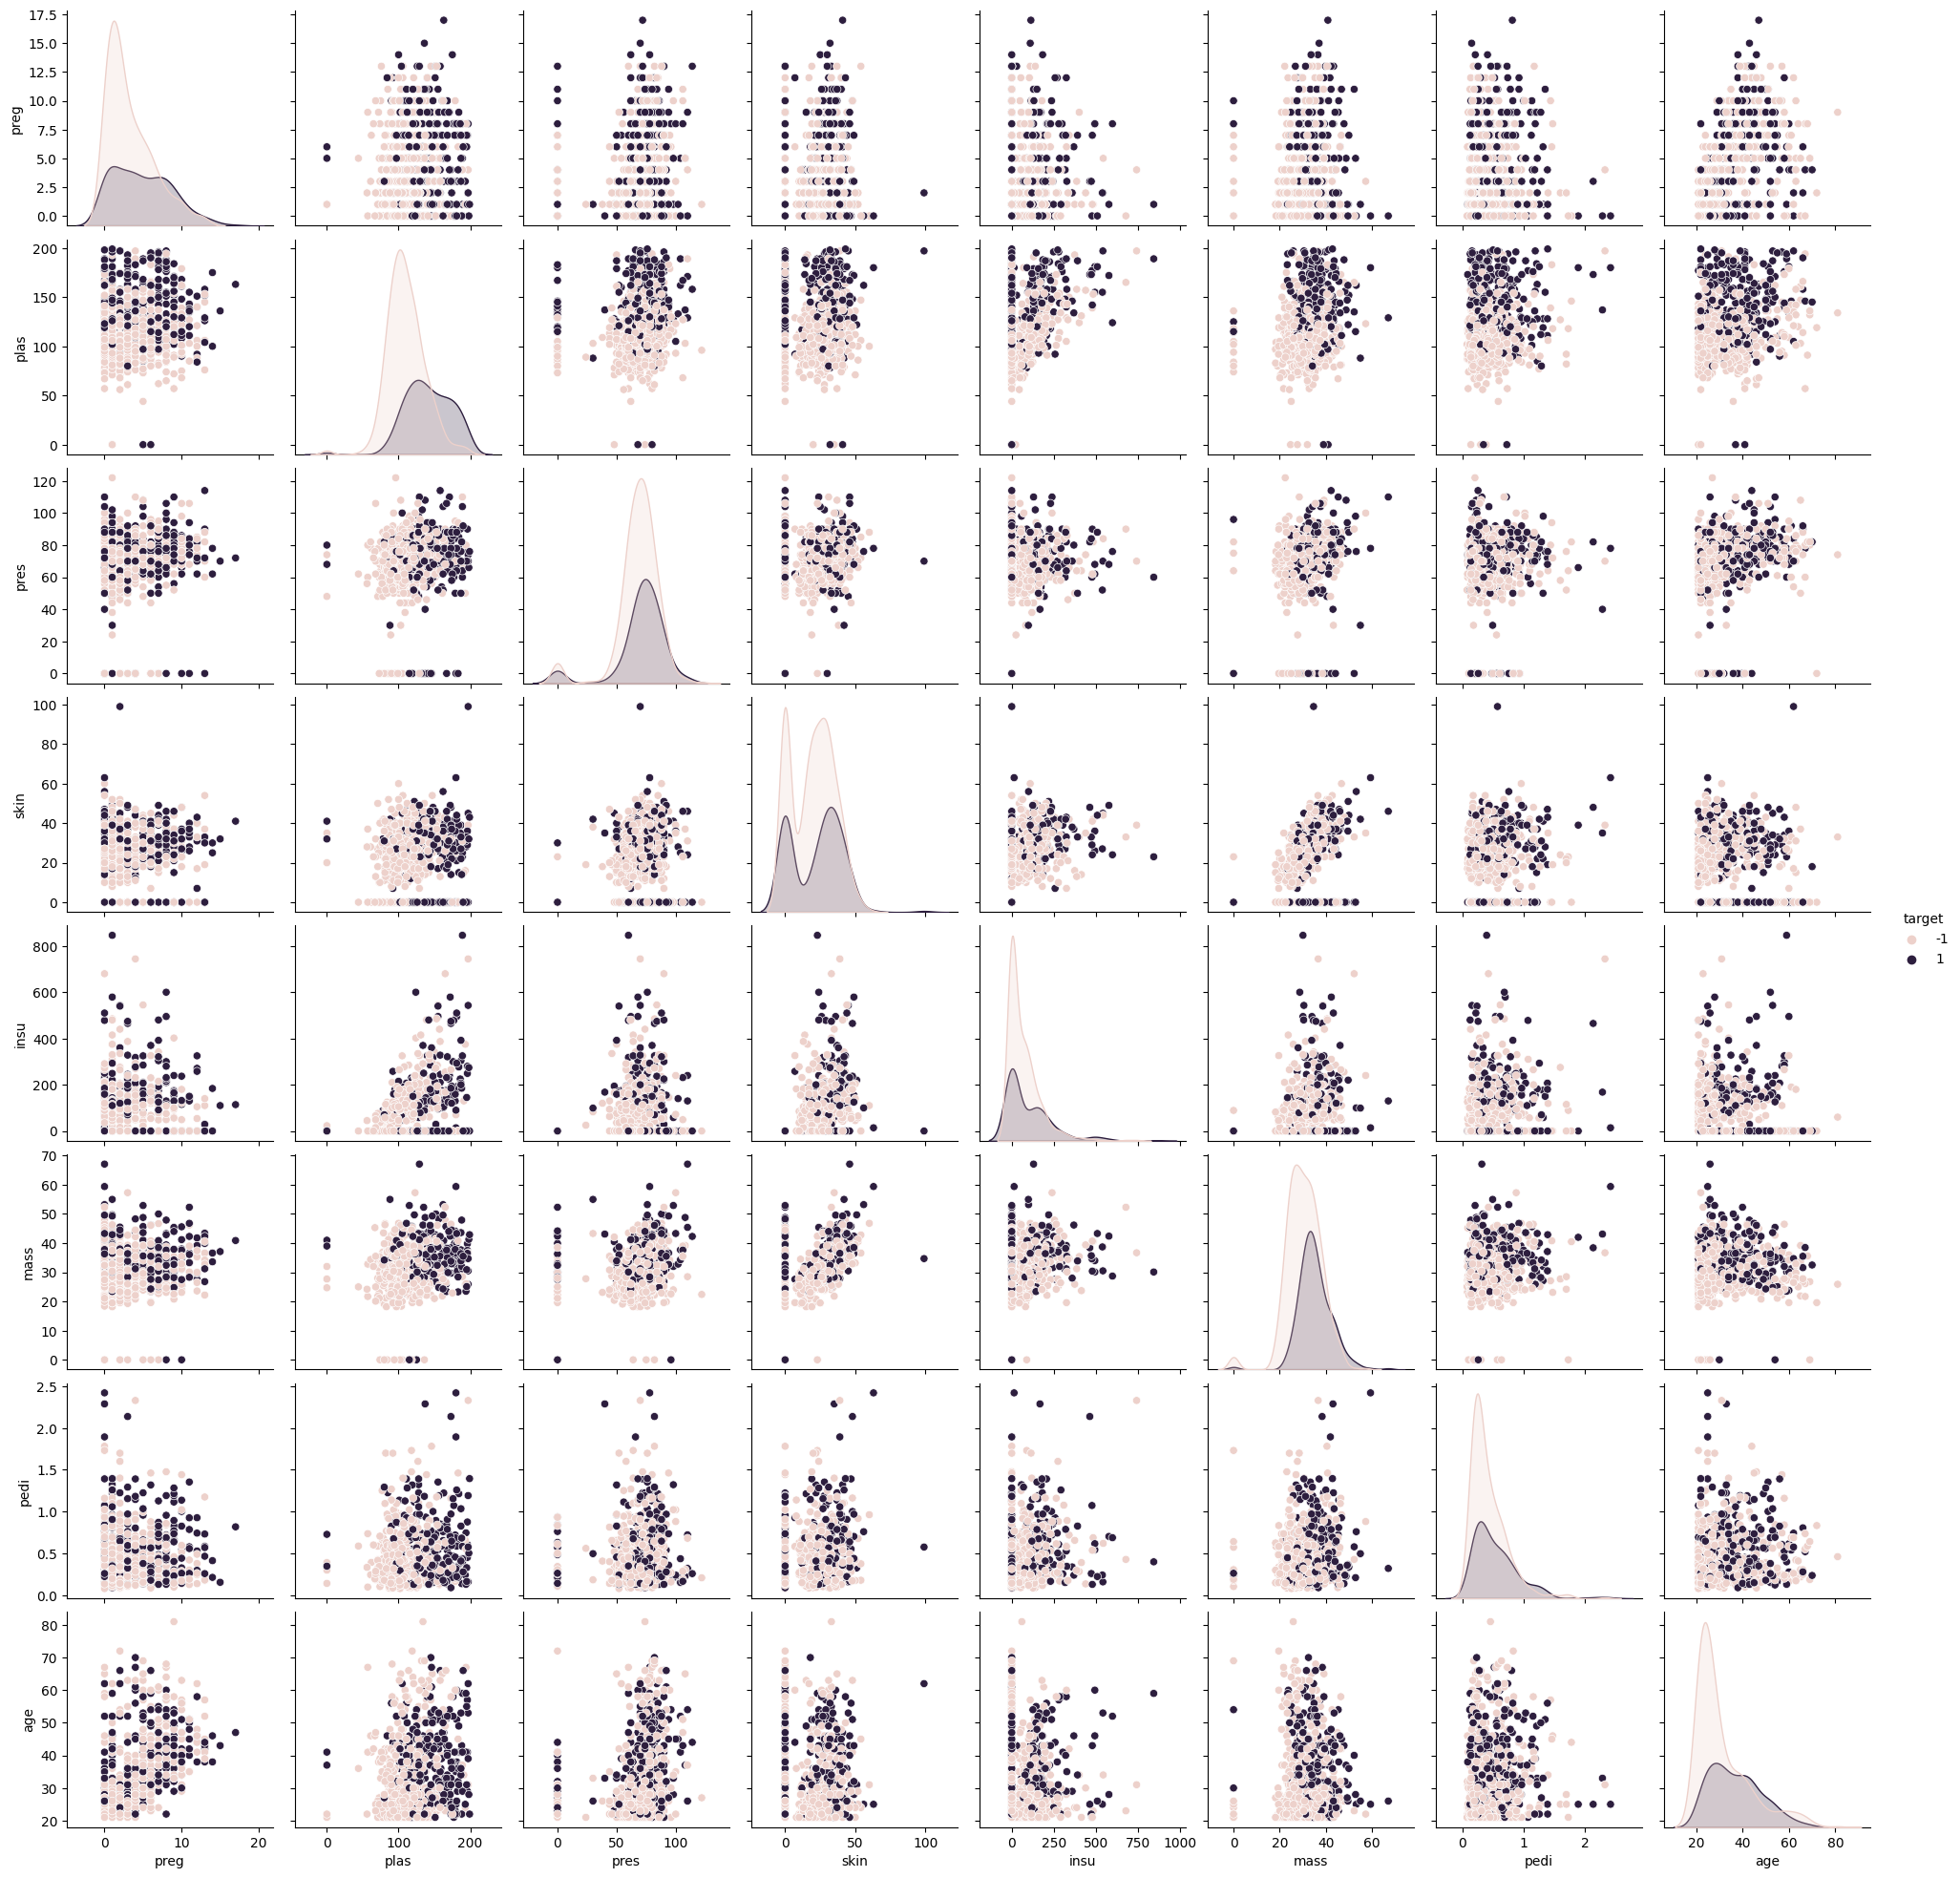

In [17]:
# Pairplot

sns.pairplot(df, hue='target')
plt.show()

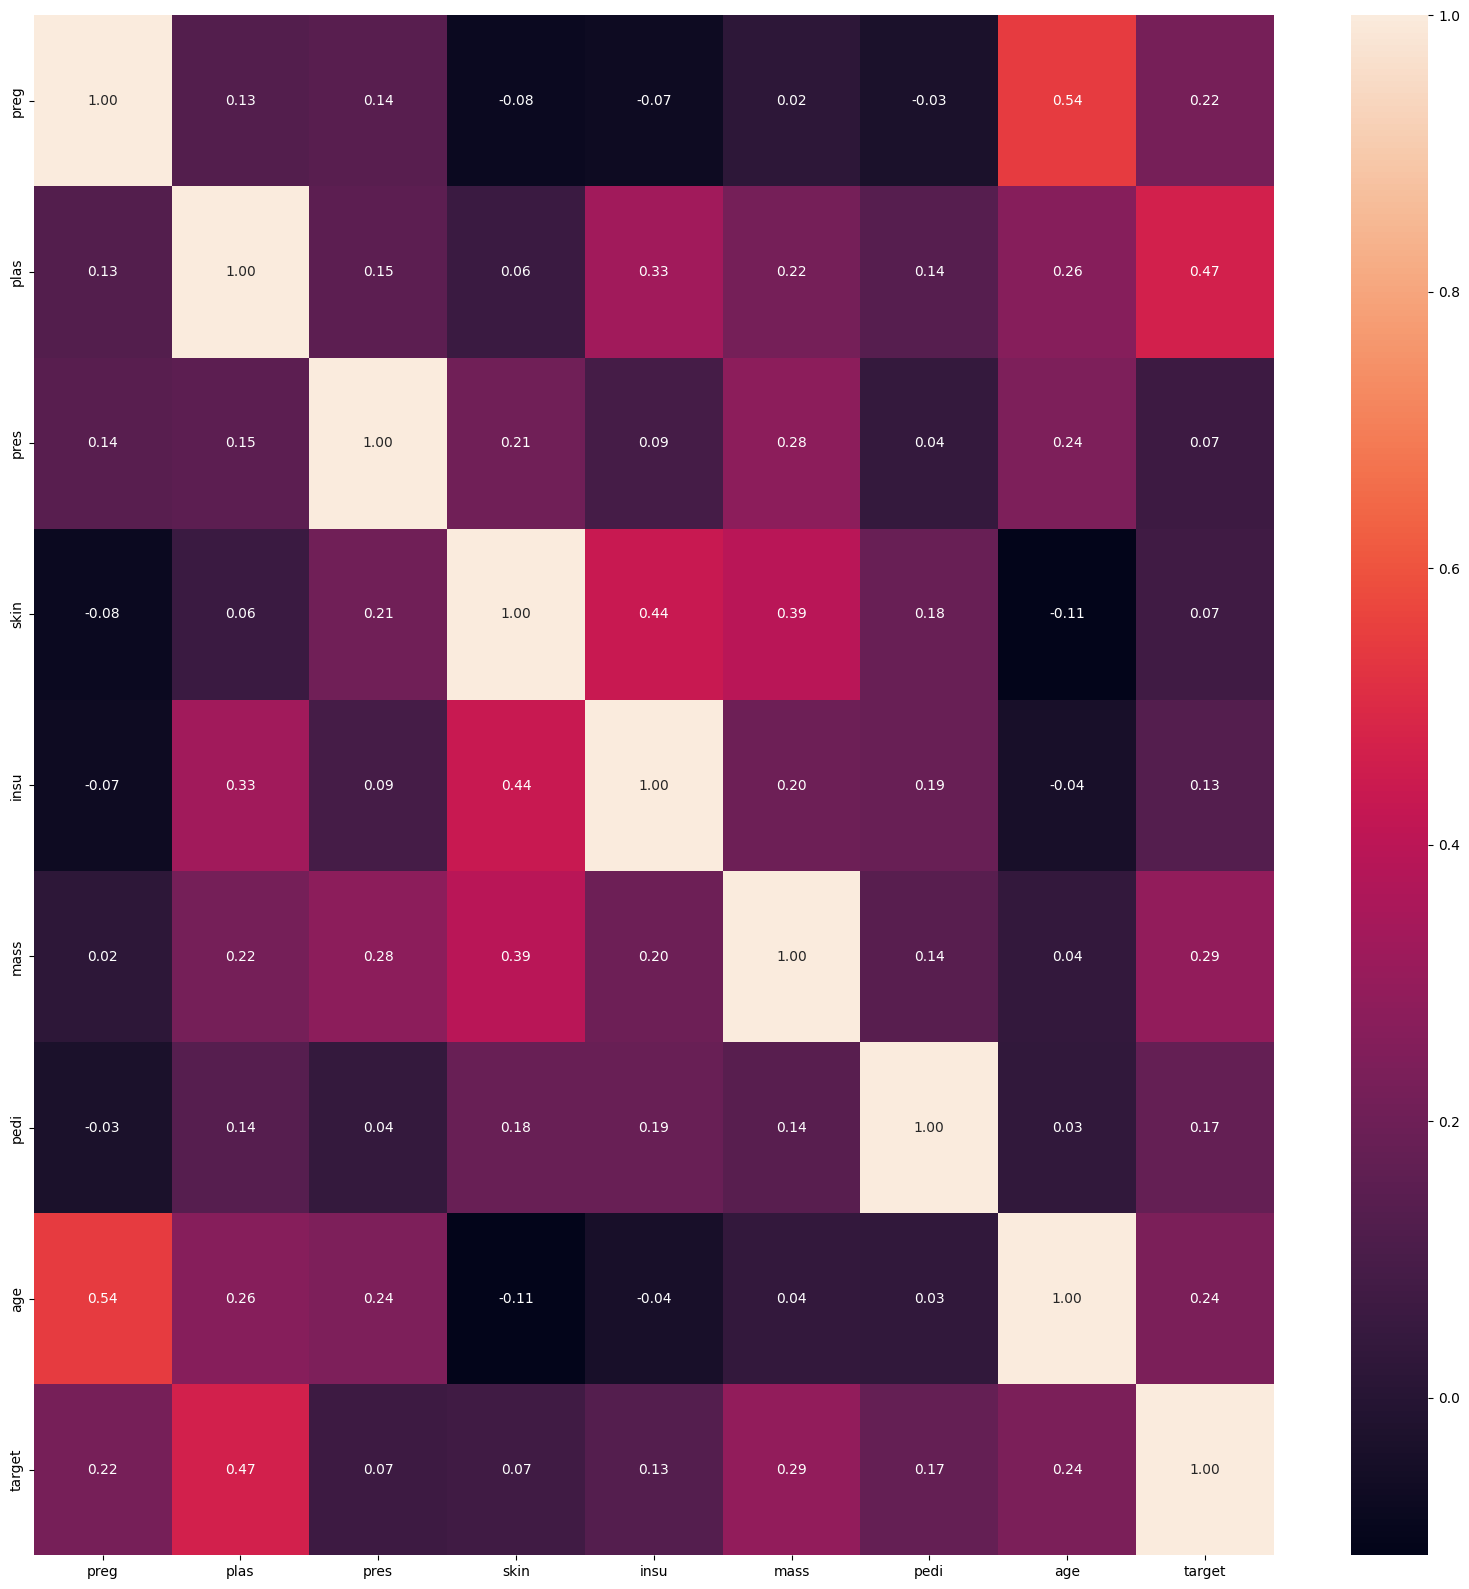

In [8]:
# Visualizar a correlação entre as features

corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f")

plt.show()

### Dado os dados, escolhemos implementar um AdaBoost Ensemble com Linear Regression


In [18]:
# Calculate purity of each attribute
def purity(df, attribute):
    '''
    Calculate purity of an attribute. Arguments:
    df: dataframe
    attribute: attribute to calculate purity of
    '''
    return df.groupby(attribute).size().max() / len(df)

import math

def ig(class_, feature):
  classes = set(class_)

  Hc = 0
  for c in classes:
    pc = list(class_).count(c)/len(class_)
    Hc += - pc * math.log(pc, 2)
  print('Overall Entropy:', Hc)
  feature_values = set(feature)

  Hc_feature = 0
  for feat in feature_values:

    pf = list(feature).count(feat)/len(feature)
    indices = [i for i in range(len(feature)) if feature[i] == feat]
    clasess_of_feat = [class_[i] for i in indices]
    for c in classes:
        pcf = clasess_of_feat.count(c)/len(clasess_of_feat)
        if pcf != 0:
            temp_H = - pf * pcf * math.log(pcf, 2)
            Hc_feature += temp_H
  ig = Hc - Hc_feature
  return ig 


In [19]:
# Compute error rate, alpha and w
def compute_error(y, y_pred, w_i):
    '''
    2. b)
    Calculate the error rate of a weak classifier m. Arguments:
    y: actual target value
    y_pred: predicted value by weak classifier
    w_i: individual weights for each observation
    
    Note that all arrays should be the same length
    '''
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):
    '''
    2. c)
    Calculate the weight of a weak classifier m in the majority vote of the final classifier.
    error: error rate from weak classifier m
    '''
    return np.log((1 - error) / error)

def update_weights(w_i, alpha, y, y_pred):
    ''' 
    3.
    Update individual weights w_i after a boosting iteration. Arguments:
    w_i: individual weights for each observation
    y: actual target value
    y_pred: predicted value by weak classifier  
    alpha: weight of weak classifier used to estimate y_pred
    '''  
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

In [20]:
class AdaBoost:
    
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M = 100):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        '''

        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            unique, counts = np.unique(y_train, return_counts=True)
            # print count of each class in y_train
            print(dict(zip(unique, counts)))
            minority_shape = dict(zip(unique, counts))[1]

            x1 = np.ones((minority_shape, X_train.shape[1]))
            x1=[X_train[i] for i, v in enumerate(y_train) if v==1.0]
            x1=np.array(x1)

            sampled_instances = SMOTE_100(x1)

            X_TrainSMOTE = np.concatenate((X_train,sampled_instances), axis = 0)

            y_sampled_instances = np.ones(minority_shape)
            y_TrainSMOTE = np.concatenate((y_train,y_sampled_instances), axis=0)
            
            # (a) Fit weak classifier and predict labels

            G_m = DecisionTreeClassifier(max_depth = 1, criterion= 'entropy', max_features= 1)     # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)

    def predict(self, X):

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        # Calculate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred
    
    def accuracy(self, y, y_pred):
        return sum(y == y_pred) / len(y)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# -------------------------------------------------------------------------------------------------

import random
from sklearn.neighbors import NearestNeighbors


def nearest_neighbour(X):
  nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
  euclidean,indices= nbs.kneighbors(X)
  return indices

def SMOTE_100(X):
    indices2 = nearest_neighbour(X)
    matrix=[]
#store the values of t into an object and randomly select a value from the object and save it to a new list that will later be added to x1 training data
    for m in range(len(indices2)):
        t=x1[indices2[m]]
        newt=pd.DataFrame(t)
        matrix.append([])
        for j in range(len(newt.columns)):
            matrix[m].append(random.choice(newt[j]))
    return matrix

unique, counts = np.unique(y_train, return_counts=True)
# print count of each class in y_train
print(dict(zip(unique, counts)))
minority_shape = dict(zip(unique, counts))[1]

x1 = np.ones((minority_shape, X_train.shape[1]))
x1=[X_train[i] for i, v in enumerate(y_train) if v==1.0]
x1=np.array(x1)

sampled_instances = SMOTE_100(x1)

X_TrainSMOTE = np.concatenate((X_train,sampled_instances), axis = 0)

y_sampled_instances = np.ones(minority_shape)
y_TrainSMOTE = np.concatenate((y_train,y_sampled_instances), axis=0)

{-1: 349, 1: 188}


In [22]:
# Fit model
ab = AdaBoost()
ab.fit(X_TrainSMOTE, y_TrainSMOTE)
# Predict on test set
y_pred = ab.predict(X_test)

Accuracy:  0.7532467532467533


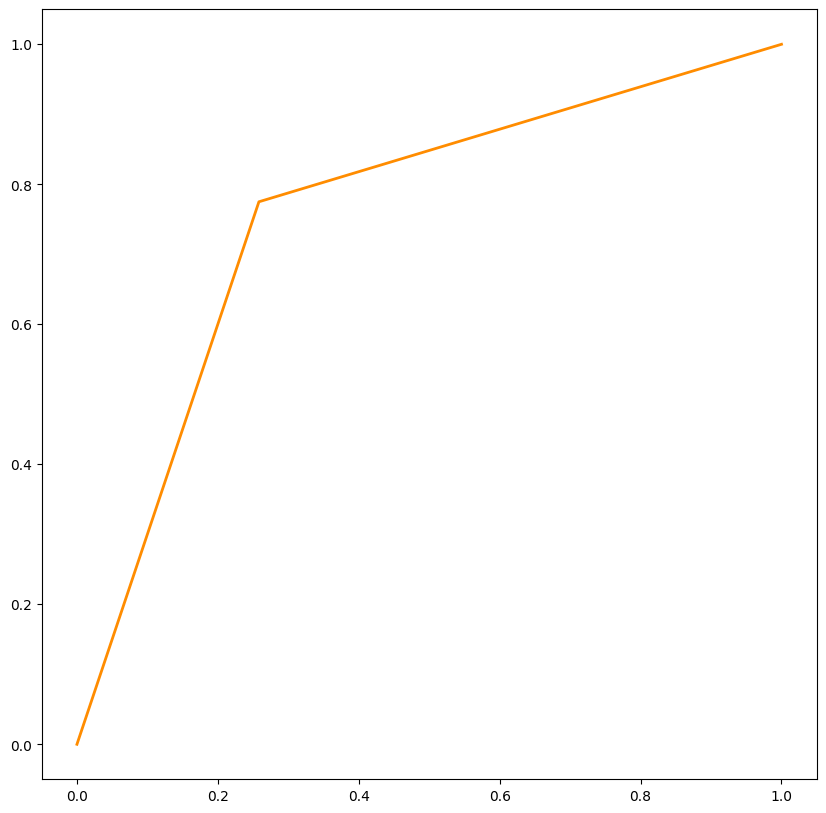

AUC:  0.7583609271523178


In [23]:
# analyse results on the prediction

# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

# Accuracy
print('Accuracy: ', ab.accuracy(y_test, y_pred))

# ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

print('AUC: ', roc_auc)

# ADA CLASSIFIER DEFAULT

0.7142857142857143


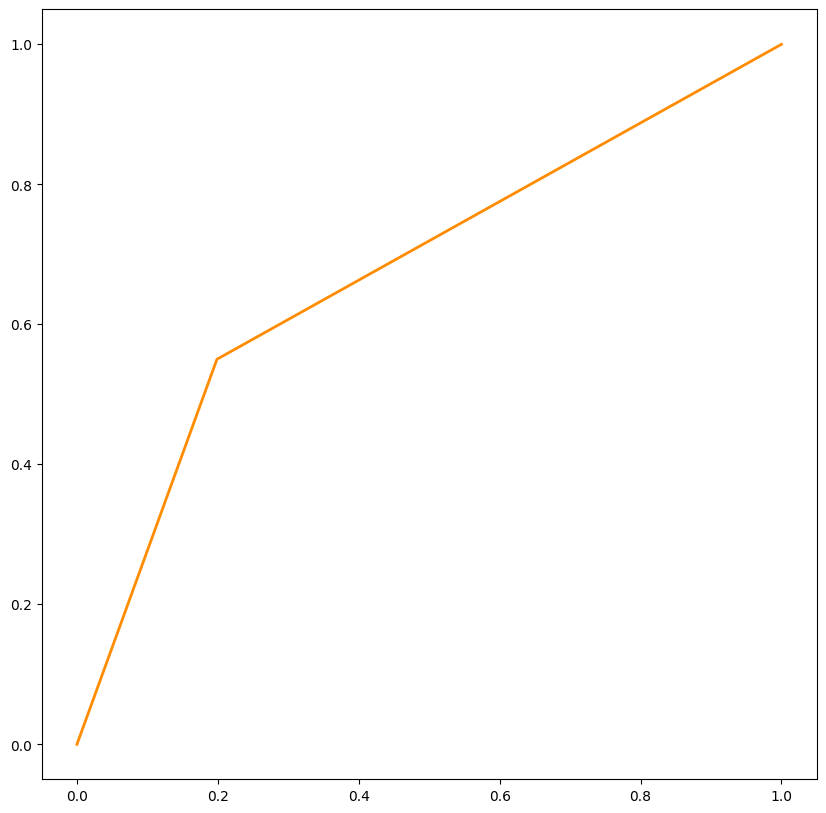

AUC:  0.6756622516556291


In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

# Fit model
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=42)

ab = AdaBoostClassifier(n_estimators = 200)
ab.fit(X_train2, y_train2)
print(ab.score(X_test2, y_test2))

# roc curve
y_pred2 = ab.predict(X_test2)
fpr, tpr, thresholds = roc_curve(y_test2, y_pred2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

print('AUC: ', roc_auc)

<AxesSubplot:>

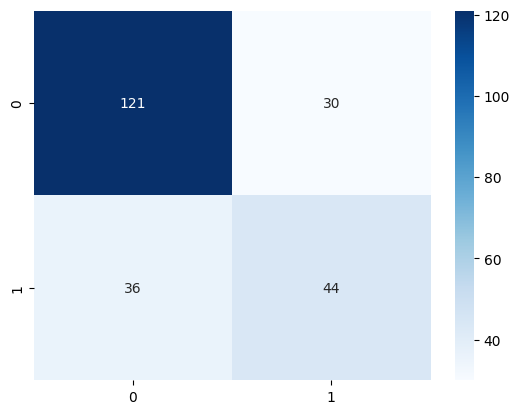

In [25]:
# plot contigency table 
sns.heatmap(confusion_matrix(y_test2, y_pred2), annot=True, fmt='d', cmap='Blues')

<AxesSubplot:>

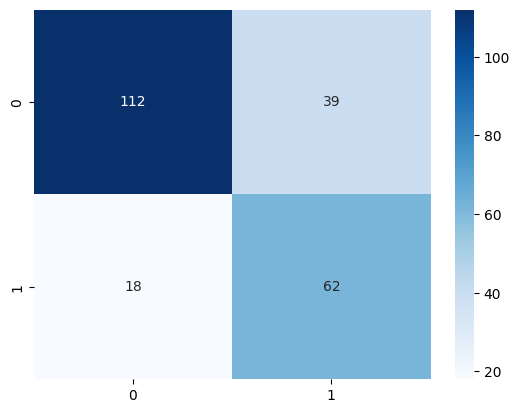

In [26]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

In [331]:
# calculate precision and recall on both models
from sklearn.metrics import precision_score, recall_score

print('Precision Nosso: ', precision_score(y_test, y_pred))
print('Recall Nosso: ', recall_score(y_test, y_pred))

print('Precision Sklearn: ', precision_score(y_test2, y_pred2))
print('Recall Sklearn: ', recall_score(y_test2, y_pred2))

Precision Nosso:  0.6354166666666666
Recall Nosso:  0.7625
Precision Sklearn:  0.5945945945945946
Recall Sklearn:  0.55


## Vamos visualizar o funcionamento em outros datasets

In [27]:
# Importar o dataset

task_id = 9914 # Supervised Classification on kr-vs-kp
task = openml.tasks.get_task(task_id)    
dataset = openml.datasets.get_dataset(task.dataset_id)
X2, y2, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)

# Visualizar o dataset
df2 = pd.DataFrame(X2, columns=attribute_names)
y2 = y2 * 2 - 1
df2['target'] = y2
df2.head()
df2.to_csv('data.csv', index=False)

<AxesSubplot:xlabel='target', ylabel='count'>

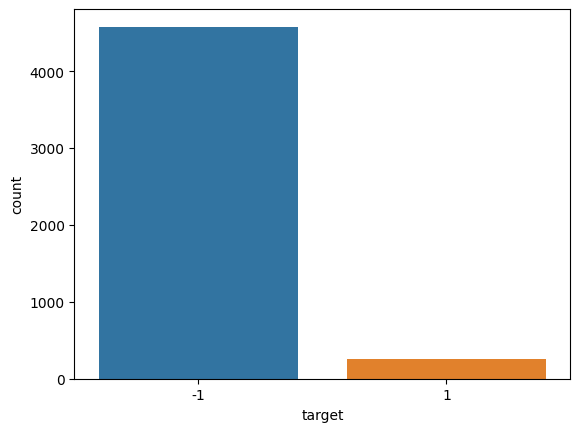

In [28]:
# Visualizar a distribuição das classes

sns.countplot(x='target', data=df2)

In [52]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

unique2, counts2 = np.unique(y2_train, return_counts=True)
minority_shape2 = dict(zip(unique2, counts2))[1]

x12 = np.ones((minority_shape2, X2_train.shape[1]))
x12=[X2_train[i] for i, v in enumerate(y2_train) if v==1.0]
x12=np.array(x12)

sampled_instances2 = SMOTE_100(x12)

X2_TrainSMOTE = np.concatenate((X2_train,sampled_instances2), axis = 0)

y2_sampled_instances = np.ones(minority_shape2)
y2_TrainSMOTE = np.concatenate((y2_train,y2_sampled_instances), axis=0)

In [53]:
# Fit model

ab2 = AdaBoost()
ab2.fit(X2_TrainSMOTE, y2_TrainSMOTE)
# Predict on test set
y2_predSMOTE = ab2.predict(X2_test)

Accuracy:  0.9738292011019284


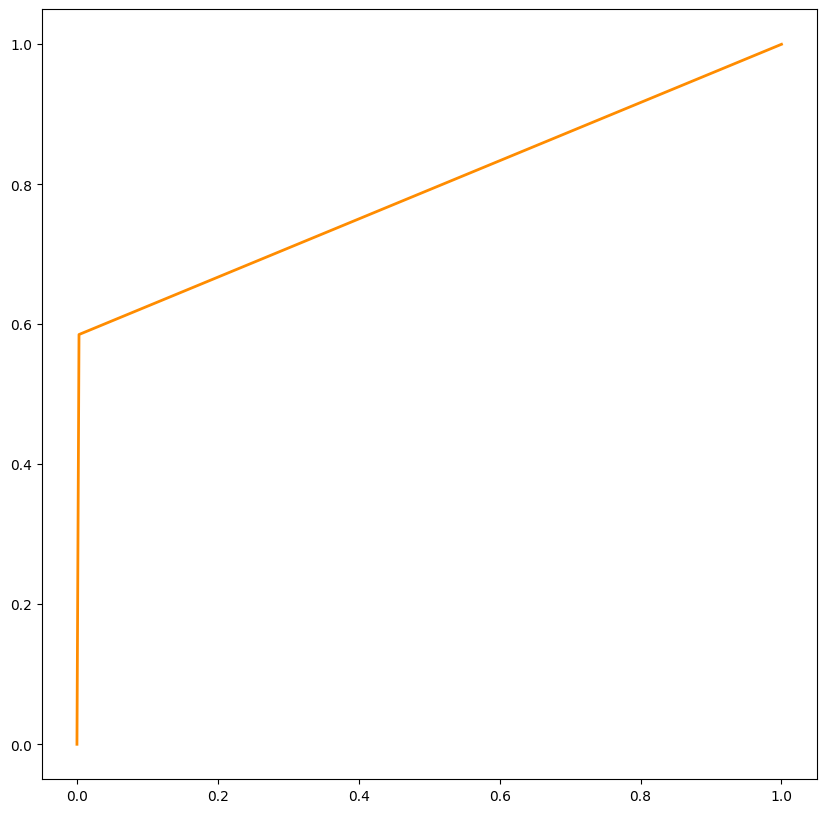

AUC:  0.7912230728146697


In [54]:
# analyse results on the prediction

# Accuracy
print('Accuracy: ', ab2.accuracy(y2_test, y2_predSMOTE))

# ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y2_test, y2_predSMOTE)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

print('AUC: ', roc_auc)

### Vamos comparar com o AdaBoost do sklearn

0.9758953168044077


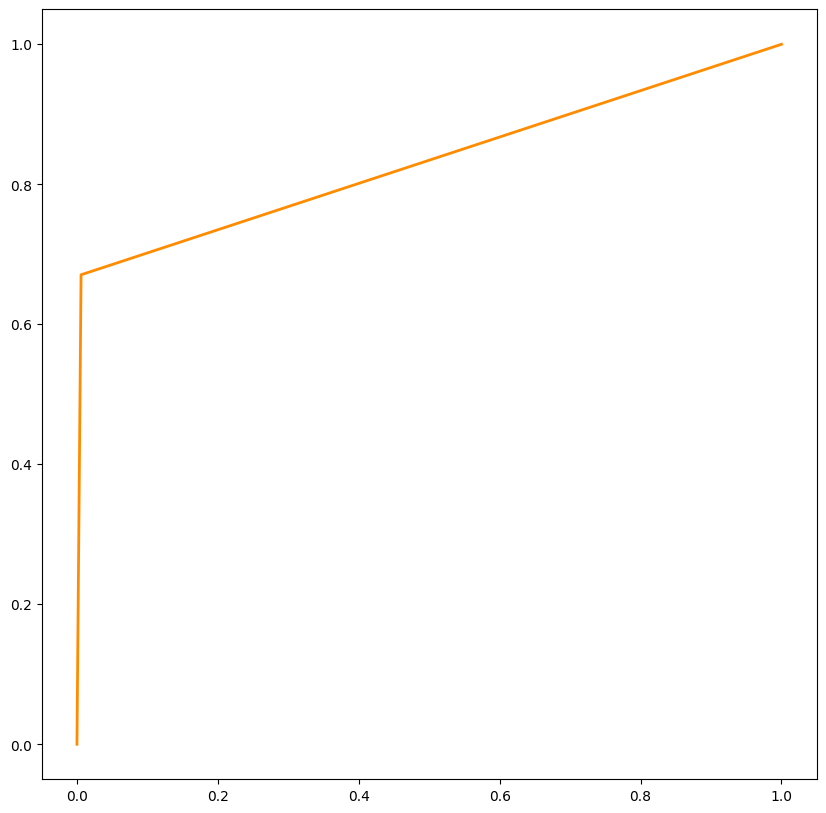

AUC:  0.8324461456293396


In [56]:
# Fit model

ab2sk = AdaBoostClassifier(n_estimators = 100)
ab2sk.fit(X2_train, y2_train)
print(ab2sk.score(X2_test, y2_test))

# roc curve

y2_pred2 = ab2sk.predict(X2_test)

fpr, tpr, thresholds = roc_curve(y2_test, y2_pred2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

print('AUC: ', roc_auc)
